## Weather

In [5]:
import requests

class Weather_Api:

  """
  A class to make weather requests to the API and return 
  a cleaned, wide-form dataframe.

  Attributes:
    token: the token to access the API
    _response: internally stores the response of data requests
    _wide_df: internally stores the wide dataframe

  Methods: 
    __init__: constructor
    _make_request: private method to request data from the API
    data_request: public method to request data from the API
    format_data: public method to clean and convert data to wide_form dataframe
  """

  def __init__(self, token='ClrbcNSEeBKQrhSQeiWqRBHkpbKGiZAI'):
    self.token = token
    self._response = None
    self._wide_df = None
  
  def make_request(self, endpoint, payload = None):
    """
    Private skeleton method to request data from the weather API, 
    passing the endpoint and payload.

    Parameters:
    - endpoint: the API provides several endpoints
    - payload: a dictionary of items specifying the request

    Returns:
    - A response object
    """
    return requests.get(
        f'https://www.ncei.noaa.gov/cdo-web/api/v2/{endpoint}',
        headers={
            'token': self.token
        },
        params=payload
    )
      
  def data_request(self,
      datasetid = 'GHCND', 
      datatypeid = ['TMAX','TMIN','TAVG'], 
      stationid = 'GHCND:USW00023234', # San Francisco Airport Daily Temperature Data
      startdate = '2022-06-26',
      enddate = '2022-07-26',
      limit = 600 # maximum allowed
  ):
    """
    Make a request to the weather API with endpoint 'data',
    specifying various parameters.

    Parameters:
    - datasetid: the id of the dataset
    - datatypeid: the ids of the datatype
    - stationid: the id of the station
    - startdate: the start date
    - enddate: the end date
    - limit: the maximum number of datapoints downloaded

    Returns:
    - A response object
    """

    self._response =  self.make_request(
      endpoint = 'data', 
      payload={
          'datasetid': datasetid, 
          'datatypeid': datatypeid,
          'stationid': stationid,
          'startdate': startdate,
          'enddate': enddate,
          'limit': limit
          }
      )
    if self._response.ok:
      self._response = self._response.json()
      print('Request successful')
      print('Here\'s the metadata:')
      print(self._response['metadata'])
    else:
      print('Request unsuccessful')
    return self._response
    
    
  def format_data(self,response=None,Tcols = ['TMAX','TMIN','TAVG']):
    """
    Takes a response object and turn it into a wide-form dataframe.
    The temperature-columns are divided by 10.
    Irrelevant columns are dropped.
    The index is converted to DateTime.

    Parameters:
    - response: the response object (if not using the internal one)
    - Tcols: the temperature columns of the query - to be divided by 10

    Returns:
    - A wide-form dataframe
    """
    if (response != None):
      self._response = response
    if (self._response == None):
      raise NameError('No valid response object')     
    self._wide_df = pd.DataFrame(self._response['results'])\
              .drop(columns=['station','attributes'])\
              .assign(value = lambda which_col: 
                          np.where(which_col.datatype.apply(lambda row: row in Tcols),
                                  which_col.value/10,
                                  which_col.value) # the second lambda is necessary because the operation is vectorized under the hood
              ).pivot(
                  index = 'date',
                  columns = 'datatype',
                  values = 'value'
              )
    self._wide_df.index = pd.to_datetime(self._wide_df.index)
    return self._wide_df

In [8]:
import datetime
current = datetime.date(2021, 8, 1)
end = datetime.date(2022, 8, 1)

api = Weather_Api()

results = []

while current < end:
    # update the cell with status information
    # display.clear_output(wait=True)
    # display.display(f'Gathering data for {str(current)}')
    
    response = api.make_request(endpoint = 'data', 
                     payload = 
        {
            'datasetid': 'GHCND', # Global Historical Climatology Network - Daily (GHCND) dataset
            'locationid': 'CITY:US060031', # SF
            'startdate': current,
            'enddate': current,
            'units': 'metric',
            'limit': 1000 # max allowed
        }
    )

    if response.ok:
        # we extend the list instead of appending to avoid getting a nested list
        results.extend(response.json()['results'])

    # update the current date to avoid an infinite loop
    current += datetime.timedelta(days=1)

In [30]:
import pandas as pd
weather = pd.DataFrame(results)

In [31]:
weather.date = pd.to_datetime(weather.date)
weather = weather.set_index(['date'])

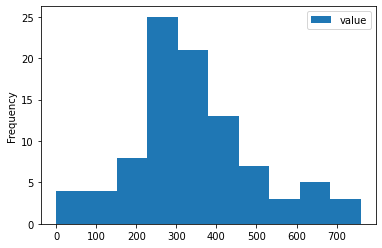

In [39]:
weather.loc[weather['datatype'] == "PRCP"].groupby('station').sum().plot(
    kind = 'hist'
)

In [45]:
weather.loc[weather['datatype'] == "PRCP"].groupby('station').agg(
    {
      'datatype':"last",
      'attributes':"last",
      'value':"sum"
    }
)

,datatype,attributes,value
station,,,
GHCND:US1CAAL0001,PRCP,",,N,0700",416.5
GHCND:US1CAAL0003,PRCP,",,N,0700",355.8
GHCND:US1CAAL0004,PRCP,",,N,0700",273.8
GHCND:US1CAAL0006,PRCP,",,N,0700",355.3
GHCND:US1CAAL0011,PRCP,",,N,1000",134.5
...,...,...,...
GHCND:USW00023234,PRCP,",,D,2400",243.9
GHCND:USW00023254,PRCP,",,D,2400",130.3
GHCND:USW00023272,PRCP,",,W,2400",263.9


In [46]:
weather.loc[weather['datatype'] == "PRCP"].groupby(['station', pd.Grouper(freq='Q')]).agg(
    {
      'datatype':"last",
      'attributes':"last",
      'value':"sum"
    }
)

datatype attributes  value
station           date                                 
GHCND:US1CAAL0001 2021-09-30     PRCP   ,,N,0700    2.0
                  2021-12-31     PRCP   ,,N,0700  311.6
                  2022-03-31     PRCP   ,,N,0700   47.8
                  2022-06-30     PRCP   ,,N,0700   55.1
                  2022-09-30     PRCP   ,,N,0700    0.0
...                               ...        ...    ...
GHCND:USW00093228 2021-09-30     PRCP   ,,W,2400    0.3
                  2021-12-31     PRCP   ,,W,2400  130.6
                  2022-03-31     PRCP   ,,W,2400   25.7
                  2022-06-30     PRCP   ,,D,2400   30.5
                  2022-09-30     PRCP   ,,D,2400    0.0

[407 rows x 3 columns]

In [47]:
weather.loc[weather['datatype'] == "PRCP"].groupby(['station', pd.Grouper(freq='Q')]).value.sum().nlargest()

station            date      
GHCND:USC00044500  2021-12-31    606.9
GHCND:US1CAMR0031  2021-12-31    571.3
GHCND:US1CAMR0054  2021-12-31    553.6
GHCND:US1CASM0013  2021-12-31    501.8
GHCND:US1CAMR0002  2021-12-31    500.2
Name: value, dtype: float64

## Covid

In [49]:
covid = pd.read_csv('cases_deaths_w_cont.csv')

In [50]:
covid.columns

Index(['Unnamed: 0', 'location', 'date', 'iso_code', 'continent',
       'total_cases', 'new_cases', 'reproduction_rate', 'population',
       'population_density', 'median_age', 'aged_65_older', 'aged_70_older',
       'gdp_per_capita', 'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'new_deaths', 'total_deaths', 'rate',
       'inst_rate', 'd_per_density', 'd_per_p'],
      dtype='object')

In [51]:
covid = covid.drop(columns=['Unnamed: 0'])

In [52]:
covid

,location,date,iso_code,continent,total_cases,new_cases,reproduction_rate,population,population_density,median_age,...,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,new_deaths,total_deaths,rate,inst_rate,d_per_density,d_per_p
0,Afghanistan,2020-03-31,AFG,Asia,166.0,5.433333,1.520000,40099462.0,54.422,18.6,...,9.59,0.5,64.83,0.511,0.444444,4.0,0.024096,0.081800,0.008167,1.108355e-08
1,Afghanistan,2020-04-30,AFG,Asia,1827.0,55.366667,1.504333,40099462.0,54.422,18.6,...,9.59,0.5,64.83,0.511,1.866667,60.0,0.032841,0.033715,0.034300,4.655092e-08
2,Afghanistan,2020-05-31,AFG,Asia,15180.0,430.741935,1.448710,40099462.0,54.422,18.6,...,9.59,0.5,64.83,0.511,6.258065,254.0,0.016733,0.014529,0.114991,1.560636e-07
3,Afghanistan,2020-06-30,AFG,Asia,31445.0,542.166667,0.973000,40099462.0,54.422,18.6,...,9.59,0.5,64.83,0.511,16.166667,739.0,0.023501,0.029819,0.297061,4.031642e-07
4,Afghanistan,2020-07-31,AFG,Asia,36628.0,167.193548,0.774194,40099462.0,54.422,18.6,...,9.59,0.5,64.83,0.511,17.290323,1275.0,0.034809,0.103415,0.317708,4.311859e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5416,Zimbabwe,2022-04-30,ZWE,Africa,247875.0,52.966667,0.770000,15993524.0,42.729,19.6,...,1.82,1.7,61.49,0.571,0.833333,5469.0,0.022064,0.015733,0.019503,5.210442e-08
5417,Zimbabwe,2022-05-31,ZWE,Africa,252398.0,145.903226,1.328387,15993524.0,42.729,19.6,...,1.82,1.7,61.49,0.571,1.096774,5503.0,0.021803,0.007517,0.025668,6.857614e-08
5418,Zimbabwe,2022-06-30,ZWE,Africa,255586.0,106.266667,0.837000,15993524.0,42.729,19.6,...,1.82,1.7,61.49,0.571,1.733333,5555.0,0.021734,0.016311,0.040566,1.083772e-07
5419,Zimbabwe,2022-07-31,ZWE,Africa,256378.0,25.548387,0.775806,15993524.0,42.729,19.6,...,1.82,1.7,61.49,0.571,0.709677,5577.0,0.021753,0.027778,0.016609,4.437280e-08


In [62]:
import plotly.express as px

fig = px.choropleth(covid, 
                    locations = 'iso_code',
                    color='d_per_p',
                    animation_frame = 'date', 
                    title = 'Covid Deaths/Population',
                    range_color = (0,0.000015))
fig.show()

KeyError: ignored

Questions:
* upload and read in the cases_deaths_w_cont.csv file and save it to a dataframe
* change the date column to be of type datetime
* group by continents to find total_cases and total_deaths by continent
* pivot the data so that the countries are the columns, the dates are the indices and the values are the new_cases.
* find the 10 countries with the highest nr of cases/deaths.
* group by the countries display the mean number of new cases and the max number of total cases

In [60]:
covid.columns

Index(['location', 'date', 'iso_code', 'continent', 'total_cases', 'new_cases',
       'reproduction_rate', 'population', 'population_density', 'median_age',
       'aged_65_older', 'aged_70_older', 'gdp_per_capita',
       'cardiovasc_death_rate', 'diabetes_prevalence',
       'hospital_beds_per_thousand', 'life_expectancy',
       'human_development_index', 'new_deaths', 'total_deaths', 'rate',
       'inst_rate', 'd_per_density', 'd_per_p'],
      dtype='object')

In [61]:
covid.date = pd.to_datetime(covid.date)

In [63]:
covid.continent.unique()

array(['Asia', 'Europe', 'Africa', 'North America', 'South America',
       'Oceania'], dtype=object)

In [64]:
covid.loc[covid.location == 'India']

,location,date,iso_code,continent,total_cases,new_cases,reproduction_rate,population,population_density,median_age,...,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,human_development_index,new_deaths,total_deaths,rate,inst_rate,d_per_density,d_per_p
2407,India,2020-03-31,IND,Asia,1397.0,44.967742,2.055882,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,1.800000,35.0,0.025054,0.040029,0.003996,1.278805e-09
2408,India,2020-04-30,IND,Asia,34863.0,1115.533333,1.678333,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,37.300000,1154.0,0.033101,0.033437,0.082812,2.649969e-08
2409,India,2020-05-31,IND,Asia,190609.0,5024.064516,1.334516,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,137.225806,5408.0,0.028372,0.027314,0.304663,9.749171e-08
2410,India,2020-06-30,IND,Asia,585481.0,13162.400000,1.214667,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,399.733333,17400.0,0.029719,0.030369,0.887470,2.839895e-07
2411,India,2020-07-31,IND,Asia,1695988.0,35822.806452,1.233548,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,616.483871,36511.0,0.021528,0.017209,1.368690,4.379793e-07
2412,India,2020-08-31,IND,Asia,3691166.0,64360.580645,1.099355,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,928.290323,65288.0,0.017688,0.014423,2.060948,6.595014e-07
2413,India,2020-09-30,IND,Asia,6312584.0,87380.600000,1.036333,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,1113.000000,98678.0,0.015632,0.012737,2.471033,7.907279e-07
2414,India,2020-10-31,IND,Asia,8184082.0,60370.903226,0.886129,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,755.903226,122111.0,0.014921,0.012521,1.678222,5.370294e-07
2415,India,2020-11-30,IND,Asia,9462809.0,42624.233333,0.951000,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,517.000000,137621.0,0.014543,0.012129,1.147820,3.673013e-07
2416,India,2020-12-31,IND,Asia,10286709.0,26577.419355,0.860645,1.407564e+09,450.419,28.2,...,10.39,0.53,69.66,0.645,366.870968,148994.0,0.014484,0.013804,0.814510,2.606425e-07


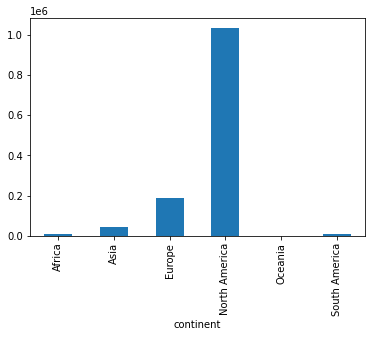

In [67]:
covid.groupby('continent').total_deaths.last().plot(
    kind = 'bar'
)

In [68]:
covid.pivot(
                  index = 'date',
                  columns = 'location',
                  values = 'new_cases'
              )

location,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Aruba,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.586207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-31,5.433333,NaN,23.064516,12.533333,0.583333,NaN,NaN,36.344828,17.161290,NaN,...,1243.129032,6195.290323,17.789474,10.117647,NaN,7.500000,NaN,NaN,NaN,0.666667
2020-04-30,55.366667,17.666667,109.666667,12.300000,0.666667,NaN,0.566667,112.466667,51.133333,1.500000,...,4649.200000,29481.300000,11.241379,62.233333,NaN,6.600000,NaN,NaN,2.366667,1.066667
2020-05-31,430.741935,11.741935,173.806452,0.612903,1.903226,NaN,0.064516,400.741935,232.774194,0.032258,...,2536.354839,22958.741935,5.806452,51.096774,NaN,37.967742,NaN,NaN,30.677419,4.800000
2020-06-30,542.166667,46.600000,150.433333,3.033333,6.600000,NaN,1.433333,1589.300000,542.000000,0.066667,...,919.233333,28561.700000,3.766667,162.666667,NaN,144.066667,NaN,NaN,17.900000,13.766667
2020-07-31,167.193548,88.419355,531.838710,2.258065,27.870968,NaN,0.766667,4089.419355,419.612903,0.580645,...,628.580645,61244.806452,10.580645,500.193548,NaN,411.032258,6.548387,NaN,140.935484,83.161290
2020-08-31,52.258065,136.677419,454.838710,8.096774,48.580645,NaN,0.096774,7304.290323,168.741935,60.806452,...,1055.709677,48360.483871,10.677419,576.903226,NaN,908.193548,15.677419,NaN,197.870968,107.354839
2020-09-30,36.866667,137.866667,234.533333,29.133333,77.266667,NaN,0.233333,11108.866667,219.266667,65.233333,...,3914.566667,39904.900000,15.033333,494.133333,NaN,946.466667,1.666667,NaN,88.733333,44.700000


In [73]:
covid.groupby('location').total_cases.last().sort_values(ascending=False).head(10)

location
United States     92102659.0
India             44145709.0
Brazil            34011173.0
Germany           31228314.0
United Kingdom    23457428.0
Italy             21286771.0
South Korea       20489128.0
Russia            18420288.0
Japan             14079172.0
Spain             13266184.0
Name: total_cases, dtype: float64

In [74]:
covid.groupby('location').total_cases.last().nlargest(10)

location
United States     92102659.0
India             44145709.0
Brazil            34011173.0
Germany           31228314.0
United Kingdom    23457428.0
Italy             21286771.0
South Korea       20489128.0
Russia            18420288.0
Japan             14079172.0
Spain             13266184.0
Name: total_cases, dtype: float64

In [75]:
covid.groupby('location').total_cases.last().sort_values().tail(10)

location
Spain             13266184.0
Japan             14079172.0
Russia            18420288.0
South Korea       20489128.0
Italy             21286771.0
United Kingdom    23457428.0
Germany           31228314.0
Brazil            34011173.0
India             44145709.0
United States     92102659.0
Name: total_cases, dtype: float64

In [76]:
covid.groupby('location').total_cases.last().sort_values().iloc[-10:,]

location
Spain             13266184.0
Japan             14079172.0
Russia            18420288.0
South Korea       20489128.0
Italy             21286771.0
United Kingdom    23457428.0
Germany           31228314.0
Brazil            34011173.0
India             44145709.0
United States     92102659.0
Name: total_cases, dtype: float64

start:stop:step

In [77]:
covid.groupby('location').agg(
    {
      'new_cases':"mean",
      'total_cases':"max",
    }
)

,new_cases,total_cases
location,,
Afghanistan,211.663871,187109.0
Albania,382.689353,316976.0
Algeria,295.955760,268141.0
Andorra,52.768259,45793.0
Angola,113.401114,102636.0
...,...,...
Venezuela,600.445998,538155.0
Vietnam,17233.672170,11346137.0
Wallis and Futuna,1.350777,761.0


## Penguins

In [91]:
!pip install palmerpenguins
from palmerpenguins import load_penguins
df = load_penguins()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [79]:
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
 7   year               344 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 21.6+ KB


In [85]:
df.loc[df.isna().any(axis=1)]

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
8,Adelie,Torgersen,34.1,18.1,193.0,3475.0,NaN,2007
9,Adelie,Torgersen,42.0,20.2,190.0,4250.0,NaN,2007
10,Adelie,Torgersen,37.8,17.1,186.0,3300.0,NaN,2007
11,Adelie,Torgersen,37.8,17.3,180.0,3700.0,NaN,2007
47,Adelie,Dream,37.5,18.9,179.0,2975.0,NaN,2007
178,Gentoo,Biscoe,44.5,14.3,216.0,4100.0,NaN,2007
218,Gentoo,Biscoe,46.2,14.4,214.0,4650.0,NaN,2008
256,Gentoo,Biscoe,47.3,13.8,216.0,4725.0,NaN,2009
268,Gentoo,Biscoe,44.5,15.7,217.0,4875.0,NaN,2009


In [94]:
index_to_drop = df.loc[df.isna().any(axis=1)].index

In [95]:
df = df.drop(index = index_to_drop)

In [97]:
df.isna().any(axis=1).sum()

0

In [98]:
df

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [100]:
df.species.unique()

array(['Adelie', 'Gentoo', 'Chinstrap'], dtype=object)

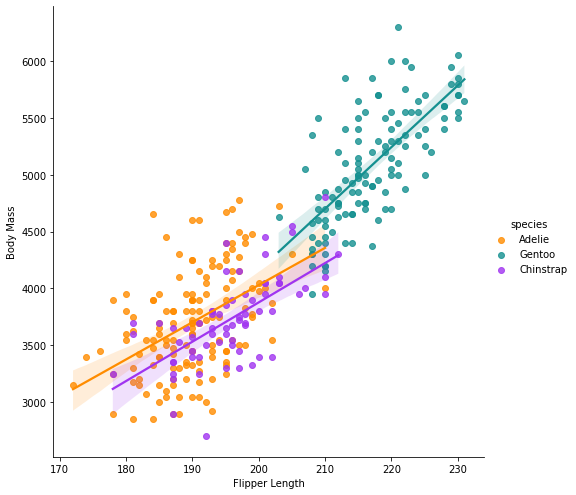

In [101]:
import seaborn as sns
g = sns.lmplot(x="flipper_length_mm",
               y="body_mass_g",
               hue="species",
               height=7,
               data=df,
               palette=['#FF8C00','#159090','#A034F0'])
g.set_xlabels('Flipper Length')
g.set_ylabels('Body Mass')

In [129]:
from sklearn.model_selection import train_test_split
y = df['species']
X = df.iloc[:,1:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [104]:
X_train

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
173,Biscoe,45.1,14.5,215.0,5000.0,female,2007
148,Dream,36.0,17.8,195.0,3450.0,female,2009
18,Torgersen,34.4,18.4,184.0,3325.0,female,2007
104,Biscoe,37.9,18.6,193.0,2925.0,female,2009
235,Biscoe,50.0,15.9,224.0,5350.0,male,2009
...,...,...,...,...,...,...,...
225,Biscoe,46.5,14.8,217.0,5200.0,female,2008
14,Torgersen,34.6,21.1,198.0,4400.0,male,2007
122,Torgersen,40.2,17.0,176.0,3450.0,female,2009
212,Biscoe,45.3,13.8,208.0,4200.0,female,2008


In [105]:
y_train

173       Gentoo
148       Adelie
18        Adelie
104       Adelie
235       Gentoo
         ...    
225       Gentoo
14        Adelie
122       Adelie
212       Gentoo
285    Chinstrap
Name: species, Length: 233, dtype: object

In [106]:
X_test

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
99,Dream,43.2,18.5,192.0,4100.0,male,2008
320,Dream,50.9,17.9,196.0,3675.0,female,2009
40,Dream,36.5,18.0,182.0,3150.0,female,2007
78,Torgersen,36.2,16.1,187.0,3550.0,female,2008
221,Biscoe,50.7,15.0,223.0,5550.0,male,2008
...,...,...,...,...,...,...,...
277,Dream,50.0,19.5,196.0,3900.0,male,2007
0,Torgersen,39.1,18.7,181.0,3750.0,male,2007
333,Dream,49.3,19.9,203.0,4050.0,male,2009
312,Dream,47.6,18.3,195.0,3850.0,female,2008


In [109]:
X_train.island.unique()

array(['Biscoe', 'Dream', 'Torgersen'], dtype=object)

In [114]:
X_train.sex.unique()

array(['female', 'male'], dtype=object)

In [110]:
from sklearn.preprocessing import LabelEncoder

In [128]:
le_island = LabelEncoder()
le_island.fit(["Biscoe","Dream","Torgersen"])
le_island.transform(["Biscoe","Dream","Dream","Dream","Torgersen"])
le_island.inverse_transform([0, 1, 1, 1, 2])
le_sex = LabelEncoder()
le_sex.fit(['male','female'])
le_species = LabelEncoder()
le_species.fit(['Adelie','Gentoo','Chinstrap'])

LabelEncoder()

In [130]:
X_train.sex = le_sex.transform(X_train.sex)
X_test.sex = le_sex.transform(X_test.sex)
X_train.island = le_island.transform(X_train.island)
X_test.island = le_island.transform(X_test.island)
y_train = le_species.transform(y_train)
y_test = le_species.transform(y_test)

In [117]:
X_train

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
173,0,45.1,14.5,215.0,5000.0,0,2007
148,1,36.0,17.8,195.0,3450.0,0,2009
18,2,34.4,18.4,184.0,3325.0,0,2007
104,0,37.9,18.6,193.0,2925.0,0,2009
235,0,50.0,15.9,224.0,5350.0,1,2009
...,...,...,...,...,...,...,...
225,0,46.5,14.8,217.0,5200.0,0,2008
14,2,34.6,21.1,198.0,4400.0,1,2007
122,2,40.2,17.0,176.0,3450.0,0,2009
212,0,45.3,13.8,208.0,4200.0,0,2008


In [131]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)

DecisionTreeClassifier()

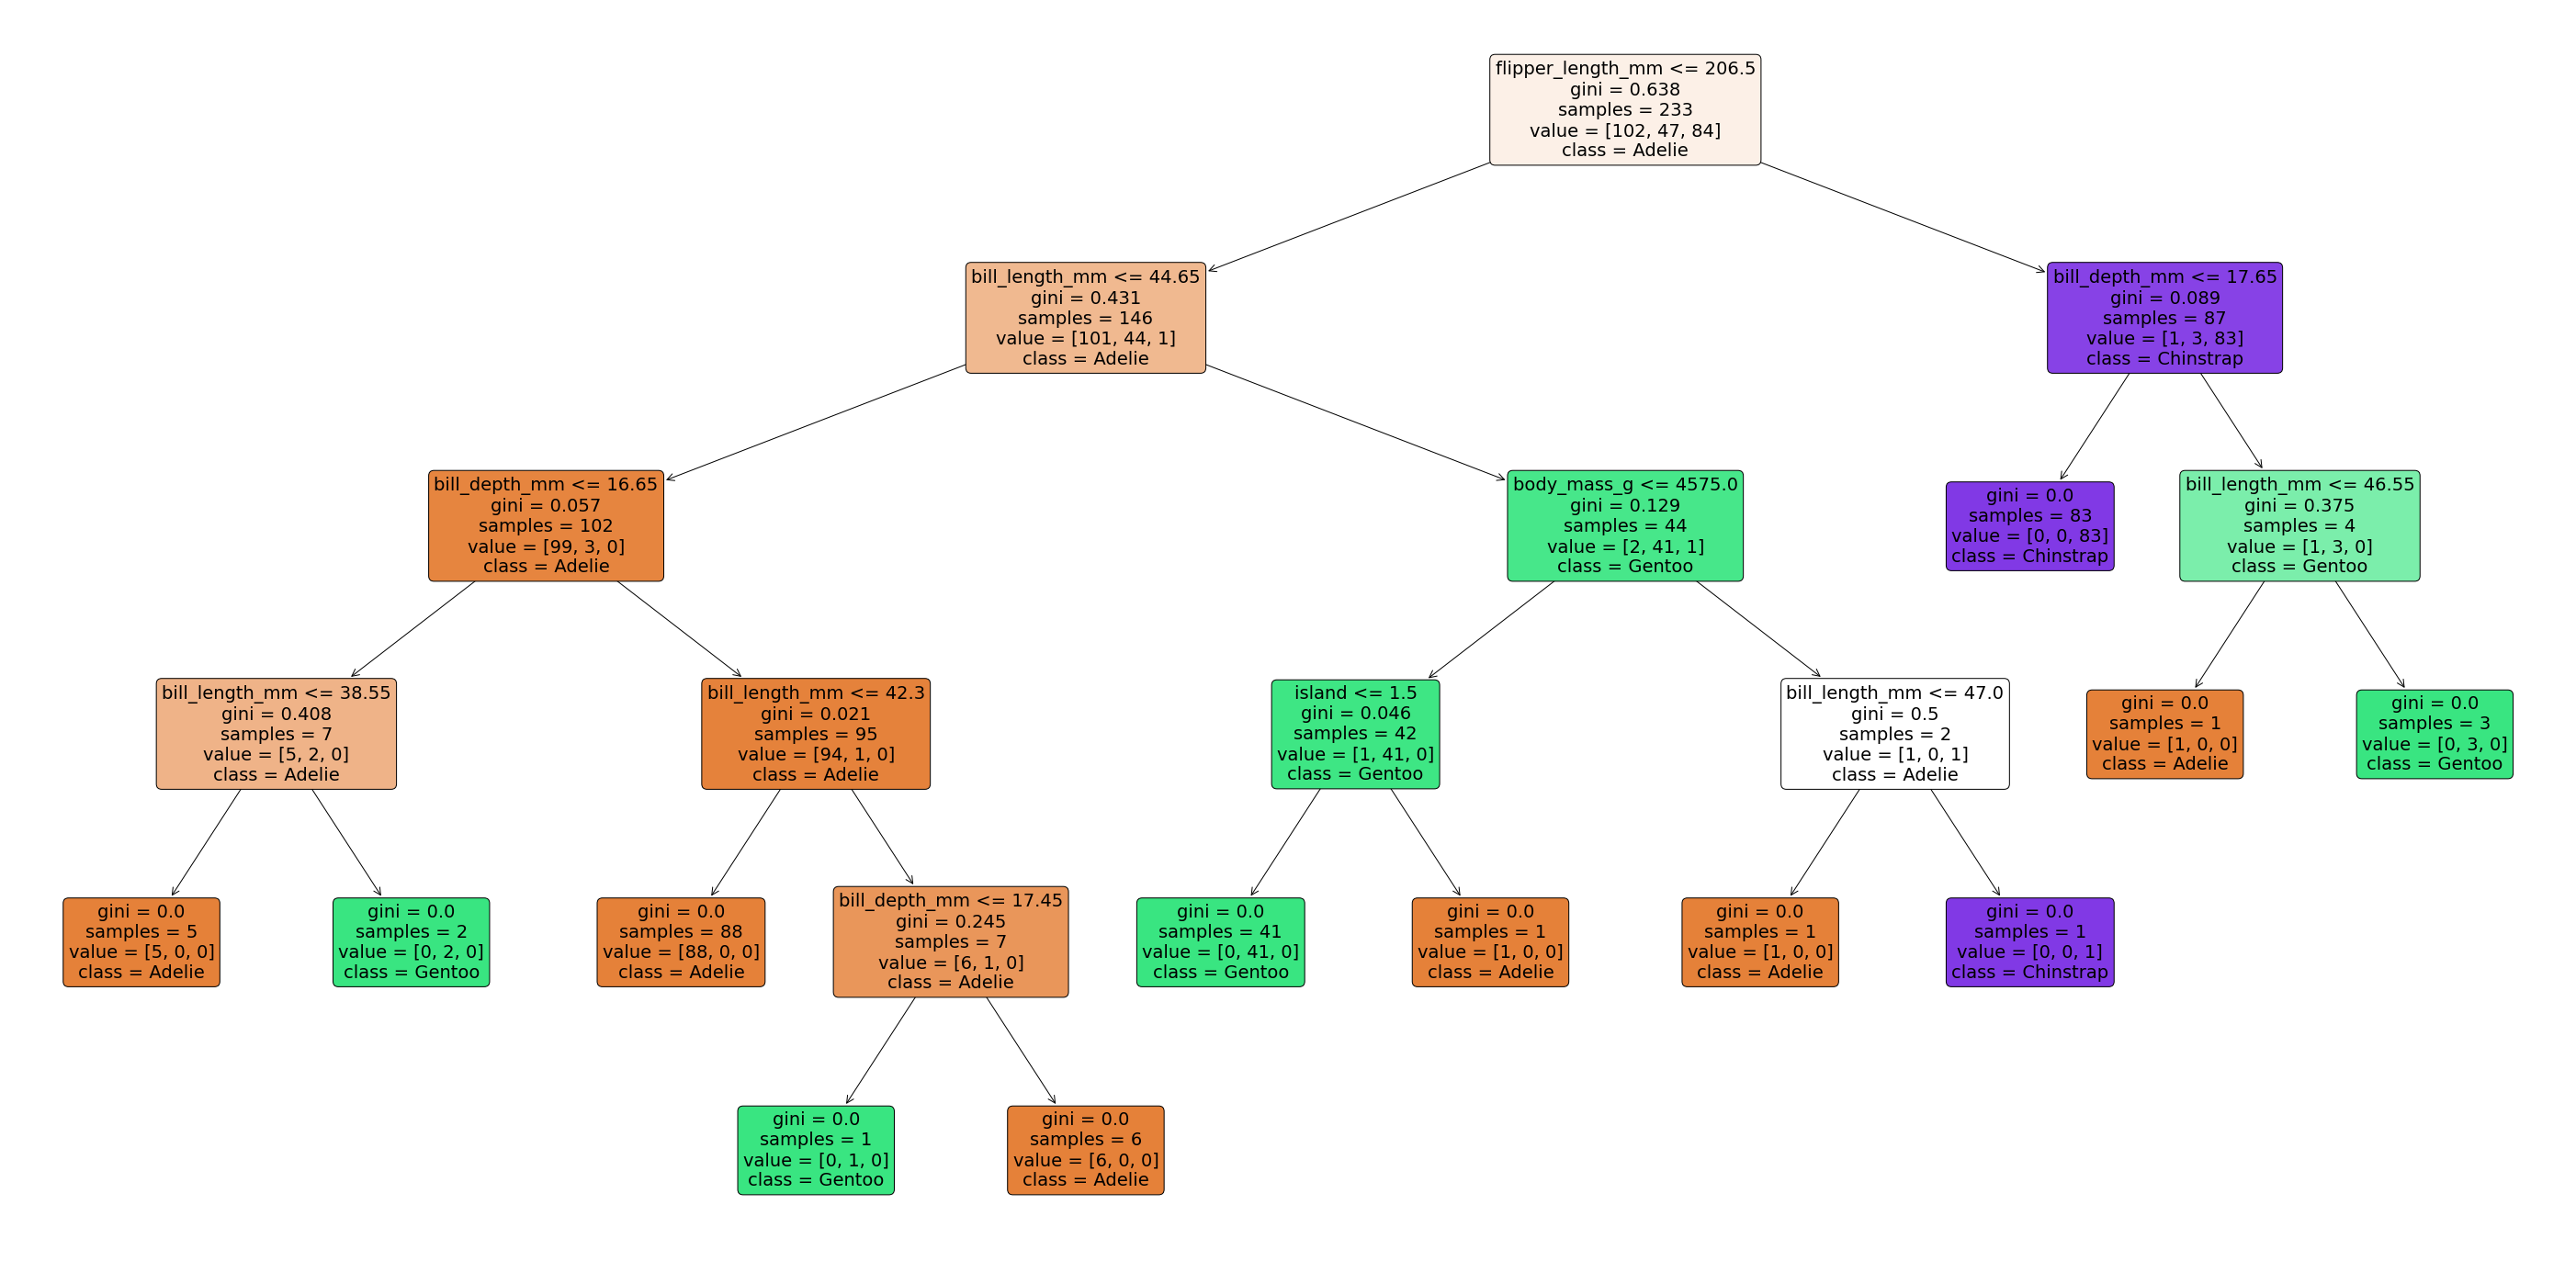

In [133]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(50,25))
plot_tree(tree,filled=True,rounded=True,feature_names = X_train.columns,class_names=['Adelie','Gentoo','Chinstrap']);

In [134]:
tree.predict(X_test)

array([2, 0, 0, 1, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 2, 0, 2, 2, 2, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0,
       2, 0, 2, 1, 1, 0, 0, 1, 1, 0, 2, 0, 2, 1, 2, 0, 2, 2, 2, 0, 2, 2,
       0, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 2, 2, 1, 2, 0, 1,
       2, 0, 1, 0, 1, 0, 1, 2, 2, 0, 0, 2])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



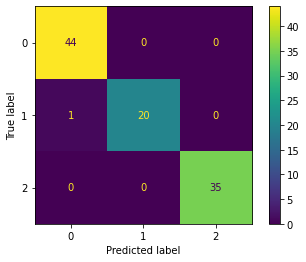

In [136]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(tree,X_test,y_test)